<a href="https://colab.research.google.com/github/yuval-ya/first-neural-network-mnist/blob/master/Part3_FullyConnectedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Digits Classification using Neural Networks



In this part we will implement our first Neural Network!
We will use fully connecter Neural Network in order to classify handwritten digits. We will use the well known MNIST dataset. The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning.
![img](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Imports

In [ ]:
%matplotlib inline
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import time
import copy


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

Mount your drive in order to run locally with colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/
from utils import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive


**QUESTION 1**: What are the problems with sigmoid?

**ANSWER**:

The problems in the sigmoid function are-
* there is a large area that the function has zero (or near zero) derivative, 
  which cause a lot of cases that we dont have gradient we can improve according to.

* there output range isn't centerlize around the zero point.








here we will implement the sigmoid activation function and it's gradient. You should not use any build-in function of sigmoid.

In [ ]:

def sigmoid(x):
    return 1/(1 + torch.exp(-1 * x))

def softmax(x):
    """
  Softmax loss function, should be implemented in a vectorized fashion (without loops)


  Inputs:
  - X: A numpy array of shape (N, C) containing a minibatch of data.
  Returns:
  - probabilities: A numpy array of shape (N, C) containing the softmax probabilities.

     """
    #for stability (do not change)
    max_per_row, inds = torch.max(x, dim=1)
    x = (x.T - max_per_row).T

    e_x = torch.exp(x)
    ones_mat = torch.ones((e_x.shape[1], e_x.shape[1]))
    mat_denominator = torch.matmul(e_x, ones_mat)
    probabilities = e_x / mat_denominator
    
    return probabilities

Implement a fully-vectorized loss function for the Softmax classifier.


In [ ]:
def cross_entropy_error(y, t):
    """
    Inputs:

    - t:  A numpy array of shape (N,C) containing  a minibatch of training label. it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: A numpy array of shape (N, C) containing the softmax probabilities (the NN's output).

    Returns a tuple of:
    - loss as single float (do not forget to divide by the number of samples in the minibatch (N))
    """

    result = 0
    log_y = torch.log(y)
    num_of_samples = t.shape[0]
    for i in range(num_of_samples):
      result+=torch.dot(t[i], log_y[i])

    result = result / num_of_samples * (-1)

    return (result)


In [ ]:
def get_accuracy(y,t):
    """
    Computes the accuracy of the NN's predictions.
    Inputs:
    - t:  A numpy array of shape (N,C) containing training labels, it is a one-hot array, 
      with t[GT]=1 and t=0 elsewhere, where GT is the ground truth label ; 
    - y: the output probabilities for the minibatch (at the end of the forward pass) of shape (N,C)
    Returns:
    - accuracy: a single float of the average accuracy.
    """
    true_predictions = 0
    num_of_samples = t.shape[0]
    for i in range(num_of_samples):
      if is_true_prediction(y[i], t[i]):
         true_predictions +=1
         
    return true_predictions / num_of_samples

def is_true_prediction(y, t):
    return torch.argmax(y) == torch.argmax(t)



## Fully-connected Network

We will design and train a two-layer fully-connected neural network with sigmoid nonlinearity and
softmax cross entropy loss. We assume an input dimension of D=784, a hidden dimension of H, and perform classification over C classes.

The architecture should be fullyconnected -> sigmoid -> fullyconnected -> softmax.

We will use torch.nn for the linear functions



### config

In [ ]:
args={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']=15  #The number of Epochs
args['validation_ratio']=0.15 #The validation ratio from training set  
args['eval_every']=1 #Will evaluate the model ever <eval_every> epochs

## load the data

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def create_train_validation_loaders(dataset: Dataset, 
                                         validation_ratio,
                                         batch_size=100):
    """
    Splits a dataset into a train and validation set, returning a
    DataLoader for each.
    :param dataset: The original dataset.
    :param validation_ratio: Ratio (in range 0,1) of the validation set size to
        total dataset size.
    :param batch_size: Batch size the loaders will return from each set.
    :return: A tuple of train, validation and test DataLoader instances.
    """
    if not(0.0 < validation_ratio < 1.0):
        raise ValueError(validation_ratio)
        
    train_set, valid_set = train_test_split(dataset, test_size=validation_ratio, shuffle=False)

    dl_train = torch.utils.data.DataLoader(
      train_set, batch_size=batch_size, shuffle=False, num_workers=2
    )
    
    dl_valid = torch.utils.data.DataLoader(
      valid_set, batch_size=batch_size, shuffle=True, num_workers=2
    )
    
    return dl_train, dl_valid

In [ ]:
#load the data
dataset = datasets.MNIST('./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor(),
                                                       transforms.Normalize((0.1307,), (0.3081,))])
                        )

train_loader, val_loader = create_train_validation_loaders(dataset, 
                                                           validation_ratio = args['validation_ratio'],
                                                           batch_size= args['batch_size'])


In [ ]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [ ]:
dataloaders = {'training':train_loader,
               'val':val_loader,
               'test':test_loader
              }

## Fully connected Neural Network

In [ ]:
class FullyConnectedNeuralNetwork(nn.Module):
    def __init__(self,
                 hidden_layer_dim
                 ):
      super(FullyConnectedNeuralNetwork, self).__init__()
      self.fc1 = nn.Linear(784, hidden_layer_dim)
      self.fc2 = nn.Linear(hidden_layer_dim, 10)
      self.softmax = softmax
      self.sigmoid = sigmoid

    def forward(self, x):
      x = torch.flatten(x, start_dim=1,end_dim=-1)
      x = self.fc1(x)
      x = self.sigmoid(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

The following functions will train our model

In [ ]:
def forward_one_epoch(loader,
                      optimizer,
                      net,
                      mode,
                      progress_bar_str,
                      num_of_epochs
                     ):
    

    losses, cur_accuracies = [], []
    all_preds,all_targets = [], []
    for batch_idx, (inputs, targets) in enumerate(loader):
        
        if mode == Mode.training:
            optimizer.zero_grad()
            
        inputs, targets =inputs.to(device), targets.to(device)
        outputs = net(inputs)

        targets = F.one_hot(targets, num_classes=10)
        targets = torch.tensor(targets, dtype=torch.float32)
        loss = cross_entropy_error(outputs, targets)
        losses.append(loss.item())

        if mode == Mode.training:
            #do a step 
            loss.backward()
            optimizer.step()
            
        if len(targets.shape) ==2:
            cur_accuracies.append(get_accuracy(outputs, targets))
            
        if batch_idx %20 ==0:
            progress_bar(batch_idx, len(loader), progress_bar_str
                   % (num_of_epochs, np.mean(losses), losses[-1], np.mean(cur_accuracies)))
            
        targets_cpu = targets.cpu().data.numpy()
        outputs_cpu = [i.cpu().data.numpy() for i in outputs]
        outputs_cpu = np.argmax(outputs_cpu, axis=1)

        all_targets.extend(targets_cpu)
        all_preds.extend(outputs_cpu)

        del inputs, targets, outputs
        torch.cuda.empty_cache()


    return losses, cur_accuracies, all_targets, all_preds




In [ ]:
def train(args, dataloaders):
  seed = 0
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

  model = FullyConnectedNeuralNetwork(hidden_layer_dim = args['hidden_layer_dim'])
  model = model.to(device)

  optimizer = torch.optim.SGD(model.parameters(), args['lr'])

  training_accuracies, val_accuracies = [], []
  training_losses, val_losses = [], [] 


  training_loader = dataloaders['training']
  val_loader = dataloaders['val']
  test_loader = dataloaders['test']

  best_acc = -1

  #start training
  for epoch in range(1, args['epochs']+1):

      #training
      model = model.train()

      progress_bar_str = 'Train: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Train Acc: %.3f%%' 

      losses, cur_training_accuracies, _,_ =  forward_one_epoch(
          loader = training_loader,
          optimizer = optimizer,
          net = model,
          mode = Mode.training,
          progress_bar_str = progress_bar_str,
          num_of_epochs = epoch)


      train_epoch_acc = np.mean(cur_training_accuracies)
      train_epoch_loss= np.mean(losses)
      sys.stdout.flush()
      print()
      print(f'Train epoch {epoch}: accuracy {train_epoch_acc}, loss {train_epoch_loss}', flush=True)
      training_accuracies.append(train_epoch_acc)
      training_losses.append(train_epoch_loss)



      # validation
      model.eval()
      if (epoch-1)%args['eval_every']==0:
          progress_bar_str = 'Validation: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | val Acc: %.3f%%'

          losses, cur_val_accuracies,_,_ =  forward_one_epoch(val_loader,
                                                                optimizer,
                                                                model,
                                                                Mode.validation,
                                                                progress_bar_str,
                                                                epoch
                                                              )
          val_epoch_acc= np.mean(cur_val_accuracies)
          val_epoch_loss= np.mean(losses)
          sys.stdout.flush()
          val_accuracies.append(val_epoch_acc)

          val_epoch_acc = np.round(val_epoch_acc,3)
          print()
          print(f'Validation epoch {epoch//args["eval_every"]}: accuracy {val_epoch_acc}, loss {val_epoch_loss}', flush=True)
          val_losses.append(val_epoch_loss)
          
          cur_acc_loss = {
            'training_accuracies':training_accuracies,
            'val_accuracies':val_accuracies,
            'training_losses':training_losses,
            'val_losses':val_losses
                        }

          if best_acc +0.001 < val_epoch_acc:

              best_acc = val_epoch_acc
              best_acc_epoch = epoch

              print(f'========== new best model! epoch {best_acc_epoch}, accuracy {best_acc}  ==========')
              best_model = copy.deepcopy(model)

              
  progress_bar_str = 'Test: repeat %d -- Mean Loss: %.3f | Last Loss: %.3f | Acc: %.3f%%'
  test_losses, test_cur_test_accuracies, test_all_targets, test_all_preds = forward_one_epoch(test_loader,
                                                                None,
                                                                best_model,
                                                                Mode.test,
                                                                progress_bar_str,
                                                                0)

  test_epoch_acc= np.mean(test_cur_test_accuracies)
  test_epoch_loss= np.mean(test_losses)
  print("===================== Test Results =====================")
  print(f'Test Accuracy : {test_epoch_acc}')
  print(f'Test Loss : {test_epoch_loss}')
  return best_model, cur_acc_loss 

## Training Process

We will finetune two hyper parameters:
1. The hidden layer dimension.
2. The learning rate.

### Finetuning hidden_layer_dim 

#### hidden_layer_dim = 1, lr = 0.0001  

Set the hidden_layer_dim to 1 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 1
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train epoch 1: accuracy 0.10354901960784313, loss 2.570097334244672

Validation epoch 1: accuracy 0.109, loss 2.5496323903401694
========== new best model! epoch 1, accuracy 0.109  ==========

Train epoch 2: accuracy 0.10354901960784313, loss 2.5617649040970147

Validation epoch 2: accuracy 0.109, loss 2.541681263181898

Train epoch 3: accuracy 0.10354901960784313, loss 2.5537194597954844

Validation epoch 3: accuracy 0.109, loss 2.5340574052598743

Train epoch 4: accuracy 0.10354901960784313, loss 2.5460225367078593

Validation epoch 4: accuracy 0.109, loss 2.5268110699123807

Train epoch 5: accuracy 0.10354901960784313, loss 2.538717844906975

Validation epoch 5: accuracy 0.109, loss 2.5199721654256186

Train epoch 6: accuracy 0.10354901960784313, loss 2.5318344854841044

Validation epoch 6: accuracy 0.109, loss 2.513559579849243

Train epoch 7: accuracy 0.10354901960784313, loss 2.5253859735002706

Validation epoch 7: accuracy 0.109, loss 2.507576862970988

Train epoch 8: accuracy 

Best val accuracy was 0.10933333333333334, at epoch 0


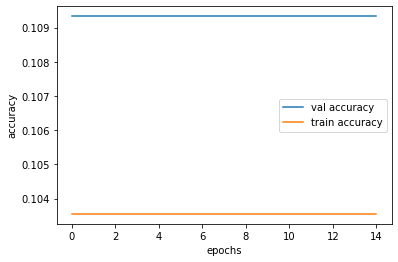

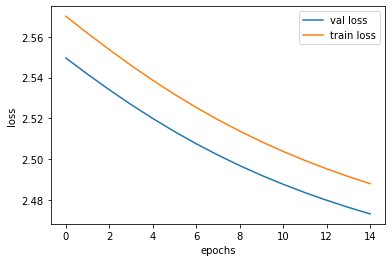

0.10933333333333334

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

the values are - 

Test Accuracy : 0.1028

Test Loss : 2.570866513252258

We can see the loss graph is decresing, but the values in a very narrow range.
We can see the accuracy graph stuck at the same point and nearly get changed.   
Our conclusion is that the forward model calculation is not wide enoungh and has less opportunity to learn (less weights to imporve).


#### hidden_layer_dim = 5, lr = 0.0001

Set the hidden_layer_dim to 5 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 5
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train epoch 1: accuracy 0.11349019607843136, loss 2.35745561356638

Validation epoch 1: accuracy 0.107, loss 2.3615378538767495
========== new best model! epoch 1, accuracy 0.107  ==========

Train epoch 2: accuracy 0.11349019607843136, loss 2.3554619480581844

Validation epoch 2: accuracy 0.107, loss 2.3595174153645835

Train epoch 3: accuracy 0.11349019607843136, loss 2.353494022406784

Validation epoch 3: accuracy 0.107, loss 2.3575220108032227

Train epoch 4: accuracy 0.11350980392156862, loss 2.3515517337649476

Validation epoch 4: accuracy 0.107, loss 2.3555526468488903

Train epoch 5: accuracy 0.1135098039215686, loss 2.3496360404818666

Validation epoch 5: accuracy 0.107, loss 2.353609985775418

Train epoch 6: accuracy 0.11349019607843136, loss 2.347746863084681

Validation epoch 6: accuracy 0.107, loss 2.3516938421461315

Train epoch 7: accuracy 0.11352941176470586, loss 2.345884112750783

Validation epoch 7: accuracy 0.107, loss 2.349804057015313

Train epoch 8: accuracy 0.1

Best val accuracy was 0.10733333333333334, at epoch 12


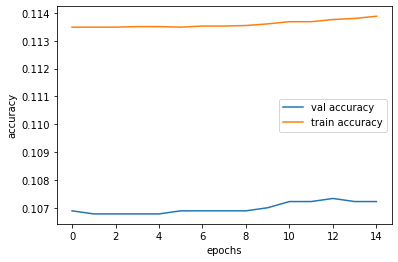

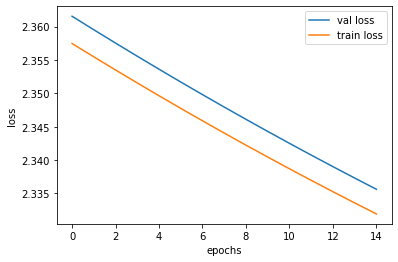

0.10733333333333334

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 

Test Accuracy : 0.11359999999999999

Test Loss : 2.3594527006149293

From those graphs, we can understand that 5 layer dimantion is also not wide enough.
In addition, The low LR cause the loss values to decrease in a very small steps that are not enough to improve the current weights .

#### hidden_layer_dim = 100, lr = 0.0001

Set the hidden_layer_dim to 100 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train epoch 1: accuracy 0.10625490196078431, loss 2.336301976559209

Validation epoch 1: accuracy 0.109, loss 2.3298676278856068
========== new best model! epoch 1, accuracy 0.109  ==========

Train epoch 2: accuracy 0.10737254901960783, loss 2.334226552177878

Validation epoch 2: accuracy 0.111, loss 2.327853282292684
========== new best model! epoch 2, accuracy 0.111  ==========

Train epoch 3: accuracy 0.1082549019607843, loss 2.332177003224691

Validation epoch 3: accuracy 0.112, loss 2.325864871342977

Train epoch 4: accuracy 0.10949019607843134, loss 2.3301536242167153

Validation epoch 4: accuracy 0.113, loss 2.32389940155877
========== new best model! epoch 4, accuracy 0.113  ==========

Train epoch 5: accuracy 0.11050980392156863, loss 2.3281548397213805

Validation epoch 5: accuracy 0.114, loss 2.3219565550486245

Train epoch 6: accuracy 0.11199999999999999, loss 2.3261806263643154

Validation epoch 6: accuracy 0.117, loss 2.320038159688314
========== new best model! epoch 6

Best val accuracy was 0.12766666666666665, at epoch 14


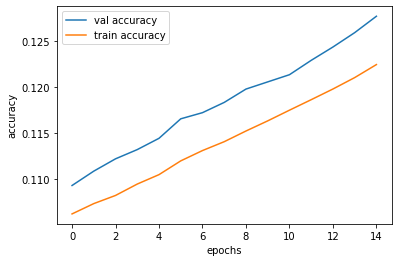

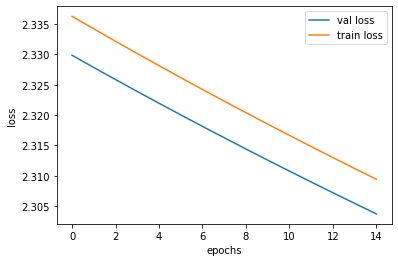

0.12766666666666665

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 
Test Accuracy : 0.12320000000000002
Test Loss : 2.311529779434204

As we saw in the previous tests, the low LR cause the model to learn slowly, the weigts get changed to the right direction but in very small steps. 


#### hidden_layer_dim = 200, lr = 0.0001

Set the hidden_layer_dim to 200 and the lr to 0.0001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 200
args['lr']=0.0001  
best_model, cur_acc_loss  = train(args, dataloaders)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train epoch 1: accuracy 0.146843137254902, loss 2.3086161099228204

Validation epoch 1: accuracy 0.154, loss 2.307937092251248
========== new best model! epoch 1, accuracy 0.154  ==========

Train epoch 2: accuracy 0.15215686274509807, loss 2.3063133557637534

Validation epoch 2: accuracy 0.16, loss 2.3056043783823648
========== new best model! epoch 2, accuracy 0.16  ==========

Train epoch 3: accuracy 0.15815686274509805, loss 2.3040627778745164

Validation epoch 3: accuracy 0.166, loss 2.3033220767974854
========== new best model! epoch 3, accuracy 0.166  ==========

Train epoch 4: accuracy 0.1641176470588235, loss 2.3018615058824126

Validation epoch 4: accuracy 0.172, loss 2.3010879622565374
========== new best model! epoch 4, accuracy 0.172  ==========

Train epoch 5: accuracy 0.17101960784313727, loss 2.2997080064287374

Validation epoch 5: accuracy 0.178, loss 2.2989006572299533
========== new best model! epoch 5, accuracy 0.178  ==========

Train epoch 6: accuracy 0.177058823

Best val accuracy was 0.232, at epoch 14


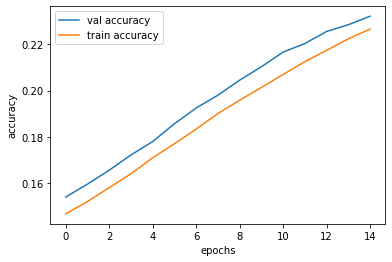

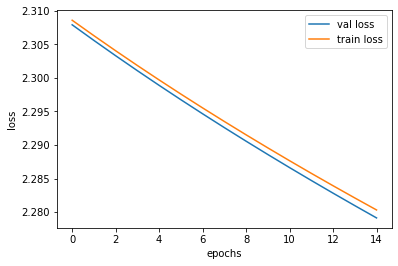

0.232

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 2.4**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 
Test Accuracy : 0.2354
Test Loss : 2.2782203912734986

From those graphs we can understand the train and test sets getting almost same results .thats means that the model isn't learning only the test samples (overfitting), it exceed to get same accuracy for both graphs. 
as for the LR, its low value affect the model like we describe above.

### Finetuning learning rate

#### hidden_layer_dim = 100, lr = 0.000001

Set the hidden_layer_dim to 100 and the lr to 0.000001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.000001  
best_model, cur_acc_loss  = train(args, dataloaders)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train epoch 1: accuracy 0.10574509803921568, loss 2.3373164850122787

Validation epoch 1: accuracy 0.107, loss 2.3318874306148953
========== new best model! epoch 1, accuracy 0.107  ==========

Train epoch 2: accuracy 0.10576470588235296, loss 2.3372954948275697

Validation epoch 2: accuracy 0.107, loss 2.331866635216607

Train epoch 3: accuracy 0.10580392156862745, loss 2.337274757086062

Validation epoch 3: accuracy 0.108, loss 2.331846687528822

Train epoch 4: accuracy 0.10580392156862745, loss 2.337253645354626

Validation epoch 4: accuracy 0.108, loss 2.3318260775672064

Train epoch 5: accuracy 0.10580392156862745, loss 2.3372328047658883

Validation epoch 5: accuracy 0.108, loss 2.331805838478936

Train epoch 6: accuracy 0.10582352941176473, loss 2.3372123521917008

Validation epoch 6: accuracy 0.108, loss 2.331786102718777

Train epoch 7: accuracy 0.10582352941176473, loss 2.3371915864009485

Validation epoch 7: accuracy 0.108, loss 2.3317658371395535

Train epoch 8: accuracy 0

Best val accuracy was 0.10777777777777779, at epoch 14


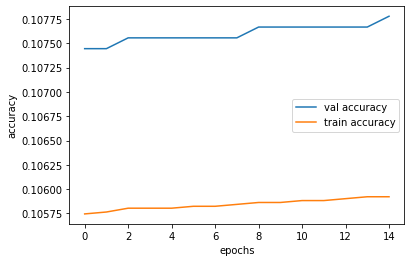

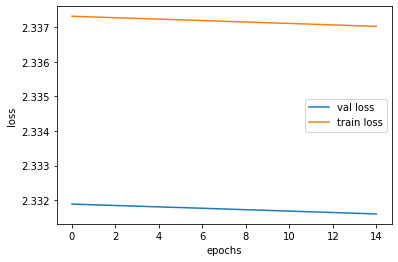

0.10777777777777779

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.1**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**:
Test Accuracy : 0.10619999999999999
Test Loss : 2.341057372093201

The LR is too low. we can see the loss value nearly doesnt get changed. the derivative of the function is almost zero during all the learning procces.  

#### hidden_layer_dim = 100, lr = 0.1

Set the hidden_layer_dim to 1 and the lr to 0.1 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']= 0.1
best_model, cur_acc_loss  = train(args, dataloaders)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train epoch 1: accuracy 0.6087058823529411, loss 1.7832368074678908

Validation epoch 1: accuracy 0.784, loss 1.2550417979558308
========== new best model! epoch 1, accuracy 0.784  ==========

Train epoch 2: accuracy 0.7927058823529411, loss 1.0228023365432142

Validation epoch 2: accuracy 0.852, loss 0.7732346124119229
========== new best model! epoch 2, accuracy 0.852  ==========

Train epoch 3: accuracy 0.8458431372549019, loss 0.7170969095884585

Validation epoch 3: accuracy 0.882, loss 0.5780054794417487
========== new best model! epoch 3, accuracy 0.882  ==========

Train epoch 4: accuracy 0.8677058823529413, loss 0.576014603469886

Validation epoch 4: accuracy 0.894, loss 0.47838329275449115
========== new best model! epoch 4, accuracy 0.894  ==========

Train epoch 5: accuracy 0.8802745098039216, loss 0.49687543511390686

Validation epoch 5: accuracy 0.9, loss 0.4197650154431661
========== new best model! epoch 5, accuracy 0.9  ==========

Train epoch 6: accuracy 0.88780392156

Best val accuracy was 0.5297777777777779, at epoch 14


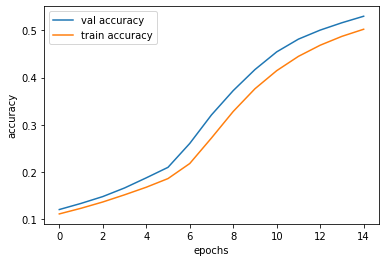

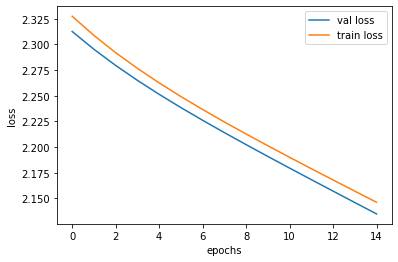

0.5297777777777779

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.2**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 
Test Accuracy : 0.9190000000000002
Test Loss : 0.293029423058033

With those LR and hidden layer dimension we can see the loss function decreacing signifactly and the accuracy values get improved for both sets.
We can understand that the bigger steps we took while changing the weights cause the model to learn how to imporve the predictions.

#### hidden_layer_dim = 100, lr = 0.001

Set the hidden_layer_dim to 100 and the lr to 0.001 and train the model.

In [ ]:
args['hidden_layer_dim'] = 100
args['lr']=0.001  
best_model, cur_acc_loss  = train(args, dataloaders)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Train epoch 1: accuracy 0.11129411764705882, loss 2.327447549969542

Validation epoch 1: accuracy 0.121, loss 2.312569777170817
========== new best model! epoch 1, accuracy 0.121  ==========

Train epoch 2: accuracy 0.12323529411764707, loss 2.3087680012572047

Validation epoch 2: accuracy 0.134, loss 2.2952632904052734
========== new best model! epoch 2, accuracy 0.134  ==========

Train epoch 3: accuracy 0.13654901960784313, loss 2.29198761547313

Validation epoch 3: accuracy 0.148, loss 2.2795251740349665
========== new best model! epoch 3, accuracy 0.148  ==========

Train epoch 4: accuracy 0.1517058823529412, loss 2.2766807453305113

Validation epoch 4: accuracy 0.166, loss 2.2649931642744274
========== new best model! epoch 4, accuracy 0.166  ==========

Train epoch 5: accuracy 0.16778431372549021, loss 2.2625117629182103

Validation epoch 5: accuracy 0.188, loss 2.2513804170820446
========== new best model! epoch 5, accuracy 0.188  ==========

Train epoch 6: accuracy 0.18609803

Best val accuracy was 0.5297777777777779, at epoch 14


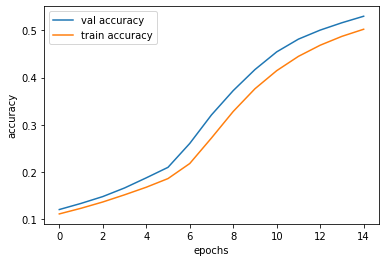

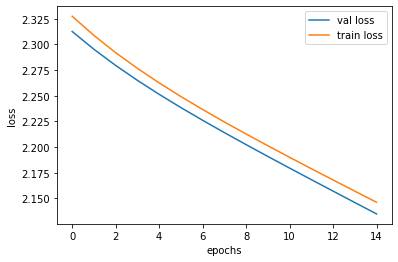

0.5297777777777779

In [ ]:
training_accuracies = cur_acc_loss['training_accuracies']
val_accuracies = cur_acc_loss['val_accuracies']
training_losses = cur_acc_loss['training_losses']
val_losses = cur_acc_loss['val_losses']
plot_graphs(training_accuracies, val_accuracies, training_losses, val_losses)

**QUESTION 3.3**: What are the accuracy and loss values? 
Explain the loss and accuracy graphs.

**ANSWER**: 
Test Accuracy : 0.5118
Test Loss : 2.139141869544983

The LR is too low, which means that when we improve the weights, the multiply of the LR with the derivative neutralize. 

**QUESTION 4:** : Suggest a way to improve the results by changing the networks's architecture  

**ANSWER**:
We can increate more hidden layer, with a varity of activation functions.
In addintion, we can change the number epocs to get the number that improve the model the best.



## Explainability

Here we will plot some of the network weights

(784, 100)


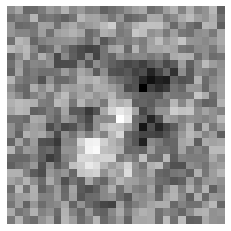

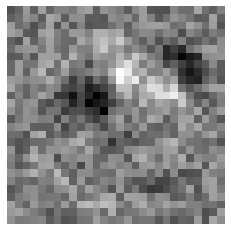

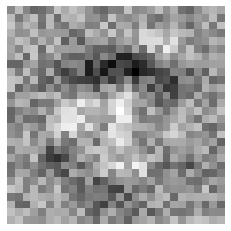

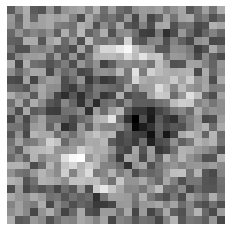

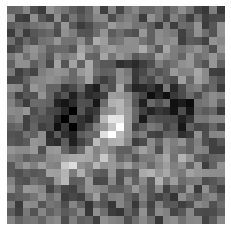

In [ ]:
# Visualize some weights. features of digits should be somehow present.
def show_net_weights(net_params):
    W1 = net_params.fc1.weight.data.numpy().T
    print(W1.shape)
    for i in range(5):
        W = W1[:,i*5].reshape(28, 28)
        plt.imshow(W,cmap='gray')
        plt.axis('off')
        plt.show()

show_net_weights(best_model)


**QUESTION 5:** Where are the bright regions? why?

**ANSWER:**
The brights reagion are found at the middle of the weights demonstration. 
The reason is that the most of the features can be found in the center area of any photo of digit.